<a href="https://colab.research.google.com/github/fid2445/Project-2/blob/main/Mike_Fiddler%20IMDB%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mike Fiddler 

In [1026]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector,make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config
set_config(display='diagram')

In [1027]:
df = pd.read_excel('/content/drive/MyDrive/Netflix Project.xlsx')
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,795222.0,27.612,8.2
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,8.2,530877.0,18.216,7.8
3,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],NaN,tt0079470,8.0,392419.0,17.505,7.8
4,tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,['horror'],['US'],NaN,tt0070047,8.1,391942.0,95.337,7.7


Data source https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies

This data set shows us all the different movies and shows available on the app Netflix.  We have imdb ratings, runtime, genre, release year.  
The goal here is to use our features to try see what gets a good imdb score.  This is a regression problem.

###Cleaning

In [1028]:
df.shape

(5806, 15)

In [1029]:
df.dtypes.value_counts().cumsum()

object      8
float64    13
int64      15
dtype: int64

Here we can see we have 15 features and 5806 rows.

With almost 6000 rows I suspect there will alot of cleaning needed before any predictions can be made.  Just in the header i can see missing values that will need addressing.

In [1030]:
type(df.loc[0,'genres'])

str

In [1031]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5806 non-null   object 
 1   title                 5805 non-null   object 
 2   type                  5806 non-null   object 
 3   description           5788 non-null   object 
 4   release_year          5806 non-null   int64  
 5   age_certification     3196 non-null   object 
 6   runtime               5806 non-null   int64  
 7   genres                5806 non-null   object 
 8   production_countries  5806 non-null   object 
 9   seasons               2047 non-null   float64
 10  imdb_id               5362 non-null   object 
 11  imdb_score            5283 non-null   float64
 12  imdb_votes            5267 non-null   float64
 13  tmdb_popularity       5712 non-null   float64
 14  tmdb_score            5488 non-null   float64
dtypes: float64(5), int64(

In [1032]:
df.duplicated().sum()

0

In [1033]:
df.isna().sum()

id                         0
title                      1
type                       0
description               18
release_year               0
age_certification       2610
runtime                    0
genres                     0
production_countries       0
seasons                 3759
imdb_id                  444
imdb_score               523
imdb_votes               539
tmdb_popularity           94
tmdb_score               318
dtype: int64

Alot of missing values need addressing.

I am going to drop the columns age_certificaion (the target audience does not effect our goal and almost half of that column is missing) and seasons (we dont care how long it ran for.)

In [1034]:
df.drop(columns='age_certification',inplace=True)

In [1035]:
df.drop(columns='seasons',inplace=True)
df.isna().sum()

id                        0
title                     1
type                      0
description              18
release_year              0
runtime                   0
genres                    0
production_countries      0
imdb_id                 444
imdb_score              523
imdb_votes              539
tmdb_popularity          94
tmdb_score              318
dtype: int64

I am also going to drop the id, title, description, production_countries, and imdb_id columns. None of these have information that relate to our goal. 

In [1036]:
df.drop(columns='id',inplace=True)
df.drop(columns='imdb_id',inplace=True)
df.drop(columns='title',inplace=True)
df.drop(columns='description',inplace=True)
df.drop(columns='production_countries',inplace=True)
df.isna().sum()

type                 0
release_year         0
runtime              0
genres               0
imdb_score         523
imdb_votes         539
tmdb_popularity     94
tmdb_score         318
dtype: int64

In [1037]:
df.head()

,type,release_year,runtime,genres,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,SHOW,1945,48,['documentation'],NaN,NaN,0.600,NaN
1,MOVIE,1976,113,"['crime', 'drama']",8.3,795222.0,27.612,8.2
2,MOVIE,1975,91,"['comedy', 'fantasy']",8.2,530877.0,18.216,7.8
3,MOVIE,1979,94,['comedy'],8.0,392419.0,17.505,7.8
4,MOVIE,1973,133,['horror'],8.1,391942.0,95.337,7.7


Now im going to make sure our cat and num values are correct.

In [1038]:
df.describe().round(2)

,release_year,runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,5806.00,5806.00,5283.00,5267.00,5712.00,5488.00
mean,2016.01,77.64,6.53,23407.19,22.53,6.82
std,7.32,39.47,1.16,87134.32,68.85,1.17
min,1945.00,0.00,1.50,5.00,0.01,0.50
25%,2015.00,44.00,5.80,521.00,3.16,6.10
50%,2018.00,84.00,6.60,2279.00,7.48,6.90
75%,2020.00,105.00,7.40,10144.00,17.78,7.50
max,2022.00,251.00,9.60,2268288.00,1823.37,10.00


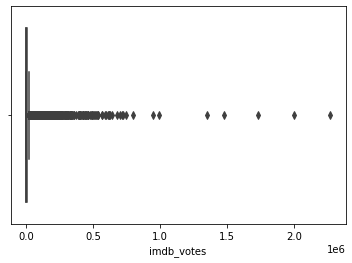

In [1039]:
sns.boxplot(x='imdb_votes', data=df);

Imdb_votes has alot of outliers and a very large range from five to over two milloion. The amount of votes a show or movie gets on imdb doesnt always translate into a better imdb score.  I will check and see if this feature correlates with any of my others. 

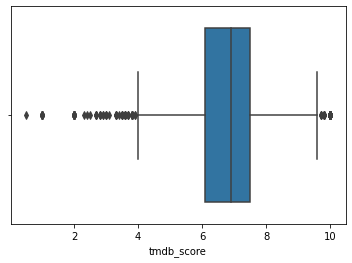

In [1040]:
sns.boxplot(x='tmdb_score', data=df);

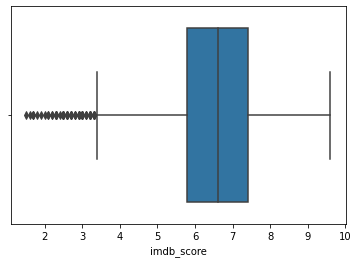

In [1041]:
sns.boxplot(x='imdb_score', data=df);

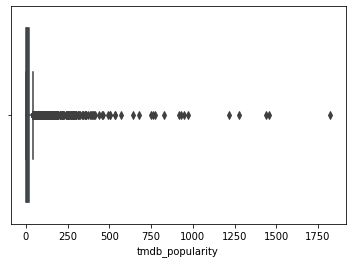

In [1042]:
sns.boxplot(x='tmdb_popularity', data=df);

Just as we saw with imdb_score, we have a ton of outliers here, once again all on the high side. 

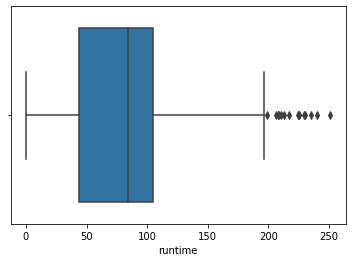

In [1043]:
sns.boxplot(x='runtime', data=df);

This is not that bad, we have a few outliers but we can see that most of our programming is in the 45-110 minute time.

In [1044]:
df['type'].value_counts()

MOVIE    3759
SHOW     2047
Name: type, dtype: int64

In [1045]:
df['genres'].value_counts()  

['comedy']                                            510
['drama']                                             350
['documentation']                                     320
['comedy', 'drama']                                   141
['drama', 'comedy']                                   128
                                                     ... 
['drama', 'family', 'comedy', 'music']                  1
['drama', 'thriller', 'western']                        1
['comedy', 'thriller', 'drama', 'action', 'crime']      1
['romance', 'drama', 'history', 'european']             1
['family', 'comedy', 'animation']                       1
Name: genres, Length: 1626, dtype: int64

1626 values, I want to break this down into fewer values so I am going to extract just the first genre of each row. 

First I remove the unwanted text from my columns.

In [1046]:
df['genres'] = df['genres'].str.replace('[','')
df['genres'] = df['genres'].str.replace(']','')
df['genres'] = df['genres'].str.replace("'",'')
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


,type,release_year,runtime,genres,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,SHOW,1945,48,documentation,NaN,NaN,0.600,NaN
1,MOVIE,1976,113,"crime, drama",8.3,795222.0,27.612,8.2
2,MOVIE,1975,91,"comedy, fantasy",8.2,530877.0,18.216,7.8
3,MOVIE,1979,94,comedy,8.0,392419.0,17.505,7.8
4,MOVIE,1973,133,horror,8.1,391942.0,95.337,7.7


Now I split the target column into the data i want to keep.

In [1047]:
df[['genre','2','3','4','5','6','7','8','9']]= df['genres'].str.split(', ',expand=True)
df.head()

,type,release_year,runtime,genres,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,genre,2,3,4,5,6,7,8,9
0,SHOW,1945,48,documentation,NaN,NaN,0.600,NaN,documentation,None,None,None,None,None,None,None,None
1,MOVIE,1976,113,"crime, drama",8.3,795222.0,27.612,8.2,crime,drama,None,None,None,None,None,None,None
2,MOVIE,1975,91,"comedy, fantasy",8.2,530877.0,18.216,7.8,comedy,fantasy,None,None,None,None,None,None,None
3,MOVIE,1979,94,comedy,8.0,392419.0,17.505,7.8,comedy,None,None,None,None,None,None,None,None
4,MOVIE,1973,133,horror,8.1,391942.0,95.337,7.7,horror,None,None,None,None,None,None,None,None


Finally I remove the old column and the excess columns.

In [1048]:
df = df.drop(columns= ['genres','2','3','4','5','6','7','8','9'])
df.head()

,type,release_year,runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,genre
0,SHOW,1945,48,NaN,NaN,0.600,NaN,documentation
1,MOVIE,1976,113,8.3,795222.0,27.612,8.2,crime
2,MOVIE,1975,91,8.2,530877.0,18.216,7.8,comedy
3,MOVIE,1979,94,8.0,392419.0,17.505,7.8,comedy
4,MOVIE,1973,133,8.1,391942.0,95.337,7.7,horror


In [1049]:
df['genre'].value_counts()

drama            1432
comedy           1310
documentation     588
thriller          442
action            292
scifi             289
romance           265
crime             254
animation         232
reality           176
fantasy           143
horror            121
                   68
family             66
music              50
war                43
western            22
history             9
sport               4
Name: genre, dtype: int64

Almost perfect, got it down to just one genre for each row.  Now I'm going to impute my missing info with the mode of our set which is drama. 

In [1050]:
df['genre'] = df['genre'].replace('1','drama')
df['genre'].value_counts()

drama            1432
comedy           1310
documentation     588
thriller          442
action            292
scifi             289
romance           265
crime             254
animation         232
reality           176
fantasy           143
horror            121
                   68
family             66
music              50
war                43
western            22
history             9
sport               4
Name: genre, dtype: int64

In [1051]:
df['genre'].nunique()

19

Perfect, from 1626 unique values down to 18

In [1052]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             5806 non-null   object 
 1   release_year     5806 non-null   int64  
 2   runtime          5806 non-null   int64  
 3   imdb_score       5283 non-null   float64
 4   imdb_votes       5267 non-null   float64
 5   tmdb_popularity  5712 non-null   float64
 6   tmdb_score       5488 non-null   float64
 7   genre            5806 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 363.0+ KB


In [1053]:
df['imdb_score'].value_counts()

6.6    201
6.8    199
6.5    193
6.2    192
7.4    190
      ... 
2.0      1
1.9      1
2.4      1
1.6      1
1.8      1
Name: imdb_score, Length: 81, dtype: int64

In [1054]:
df['imdb_score'].describe()

count    5283.000000
mean        6.533447
std         1.160932
min         1.500000
25%         5.800000
50%         6.600000
75%         7.400000
max         9.600000
Name: imdb_score, dtype: float64

That looks good.

In [1055]:
df['imdb_votes'].value_counts()

43.0        11
25.0        11
30.0         9
14.0         9
74.0         9
            ..
103.0        1
399.0        1
278223.0     1
28718.0      1
10418.0      1
Name: imdb_votes, Length: 3831, dtype: int64

In [1056]:
df['imdb_votes'].describe()

count    5.267000e+03
mean     2.340719e+04
std      8.713432e+04
min      5.000000e+00
25%      5.210000e+02
50%      2.279000e+03
75%      1.014400e+04
max      2.268288e+06
Name: imdb_votes, dtype: float64

In [1057]:
df['tmdb_popularity'].value_counts()

1.400     66
0.600     57
1.960      8
2.744      7
0.840      7
          ..
70.563     1
7.434      1
33.558     1
60.496     1
0.979      1
Name: tmdb_popularity, Length: 4943, dtype: int64

In [1058]:
df['tmdb_popularity'].describe()

count    5712.000000
mean       22.525660
std        68.849177
min         0.009442
25%         3.155250
50%         7.478000
75%        17.775750
max      1823.374000
Name: tmdb_popularity, dtype: float64

In [1059]:
df['release_year'].value_counts()

2019    848
2020    805
2018    774
2021    758
2017    580
       ... 
1974      1
1959      1
1962      1
1978      1
1945      1
Name: release_year, Length: 67, dtype: int64

In [1060]:
df['release_year'].describe()

count    5806.000000
mean     2016.013434
std         7.324883
min      1945.000000
25%      2015.000000
50%      2018.000000
75%      2020.000000
max      2022.000000
Name: release_year, dtype: float64

In [1061]:
df['tmdb_score'].value_counts()

7.0    285
7.3    208
6.8    207
6.5    204
7.4    201
      ... 
2.3      1
3.1      1
0.5      1
3.4      1
2.5      1
Name: tmdb_score, Length: 78, dtype: int64

In [1062]:
df['tmdb_score'].describe()

count    5488.000000
mean        6.818039
std         1.171560
min         0.500000
25%         6.100000
50%         6.900000
75%         7.500000
max        10.000000
Name: tmdb_score, dtype: float64

In [1063]:
df_ml = df.copy() # we need a copy before any imputation to prevent data leakage
df_km = df.copy()

In [1064]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             5806 non-null   object 
 1   release_year     5806 non-null   int64  
 2   runtime          5806 non-null   int64  
 3   imdb_score       5283 non-null   float64
 4   imdb_votes       5267 non-null   float64
 5   tmdb_popularity  5712 non-null   float64
 6   tmdb_score       5488 non-null   float64
 7   genre            5806 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 363.0+ KB


Data types are correct, we have 4 columns missing data.  As i dont want to skew the data too much i am going to use the mean of imdb_score and tmdb_score to impute for those columns.  For tmdb_popularity and imdb_votes I am going to use the median of those columns because I dont want the outliers skewing my imputation.

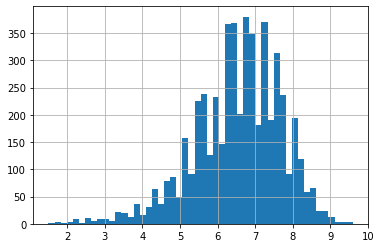

In [1065]:
df['imdb_score'].hist(bins=50);

Before we impute i wanted to get a visual of how our scores are allocated. We see most shows/movies score between a rating of 6 to 8.

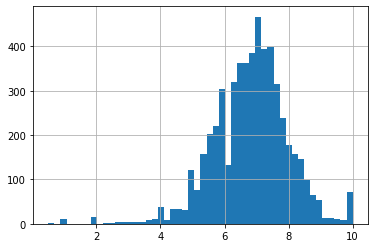

In [1066]:
df['tmdb_score'].hist(bins=50);

The tmbd movie scores follow in a similar pattern.

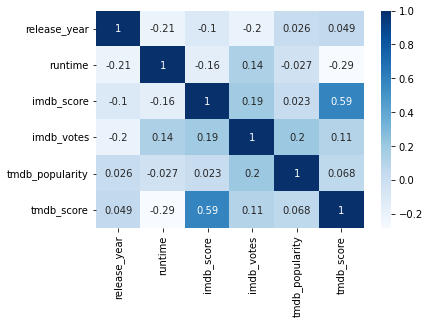

In [1067]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Blues', annot = True);

Okay so we can see the moderate correlation between imdb and tmdb scores, nothing else has a strong correlation.

In [1068]:
imdb_score_mean = df['imdb_score'].mean()
df['imdb_score'].fillna(imdb_score_mean, inplace=True)
df['imdb_score'].isna().sum()

0

In [1069]:
imdb_votes_median = df['imdb_votes'].median()
df['imdb_votes'].fillna(imdb_votes_median, inplace=True)
df['imdb_votes'].isna().sum()

0

In [1070]:
tmdb_pop_median = df['tmdb_popularity'].median()
df['tmdb_popularity'].fillna(tmdb_pop_median, inplace=True)
df['tmdb_popularity'].isna().sum()

0

In [1071]:
tmdb_score_mean = df['tmdb_score'].mean()
df['tmdb_score'].fillna(tmdb_score_mean, inplace=True)
df.isna().sum()

type               0
release_year       0
runtime            0
imdb_score         0
imdb_votes         0
tmdb_popularity    0
tmdb_score         0
genre              0
dtype: int64

Perfect, no missing data!

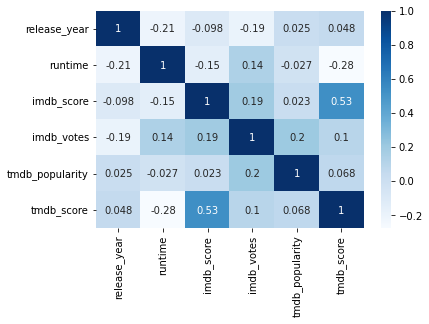

In [1072]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Blues', annot = True);

After imputing we notice that our correlation between imdb_score and tmdb_score has gone down by a few percentage points, shouldnt be a big deal. Nothing else has changed. 

## Visuals

Our only noticable correlation thus far is between IMDB_Score and TMDB_Score. 

There is a slight correlation between 'runtime' and 'tmdb_score' at .28.

We do have a very weak correlation between imdb_votes and imdb_score. Also just as weak we have a correlation between imdb_votes and tmdb_popularity. 

In [1073]:
tmdb_score = df['tmdb_score'].values
runtime = df['runtime'].values

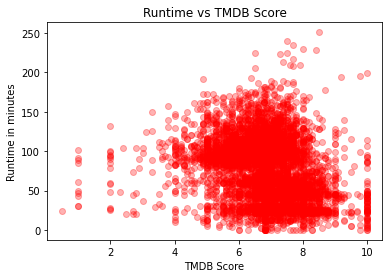

In [1074]:
plt.scatter(tmdb_score, runtime, c = 'red', alpha= .3);
plt.ylabel('Runtime in minutes');
plt.xlabel('TMDB Score')
plt.title('Runtime vs TMDB Score')
plt.show;

The darker the red, the more points there are in one spot.  This shows us our relationship between TMDB_score and runtime. The bottom right of our plot shows us that shorter shows/movies (we dont know which type they fall into) have a slightly higher TMDB_Score.

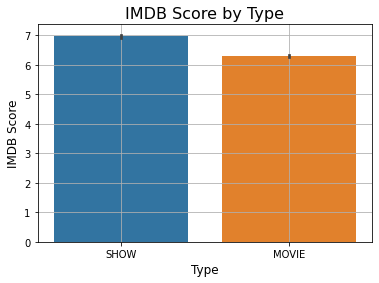

In [1075]:
sns.barplot(data = df, x = 'type', y = 'imdb_score', order = ['SHOW','MOVIE']);
plt.title('IMDB Score by Type', fontsize=16)
plt.xlabel('Type',fontsize = 12)
plt.ylabel('IMDB Score', fontsize =12 );
plt.grid()

## ML prep

In [1076]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             5806 non-null   object 
 1   release_year     5806 non-null   int64  
 2   runtime          5806 non-null   int64  
 3   imdb_score       5283 non-null   float64
 4   imdb_votes       5267 non-null   float64
 5   tmdb_popularity  5712 non-null   float64
 6   tmdb_score       5488 non-null   float64
 7   genre            5806 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 363.0+ KB


I am missing data in my target column (imdb_score).  Because I cant model with missing values I am going to drop all the rows that are missing the imdb_score.

In [1077]:
df_ml.dropna(subset=['imdb_score'], inplace=True)
df_ml.isna().sum()

type                 0
release_year         0
runtime              0
imdb_score           0
imdb_votes          16
tmdb_popularity     84
tmdb_score         228
genre                0
dtype: int64

Time to split, then setup selectors and pipelines, then we can impute.

In [1078]:
#Validation split
X = df_ml.drop(columns=['imdb_score'])
y = df_ml['imdb_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [1079]:
#making our ohe pipeline, selector(s) first
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

As I did for EDA im going to use the median of each column to impute our missing values. We want to use median because we do not want the outliers skewing the imputation.

In [1080]:
# Imputers
median_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

i had originally wanted to use mean to impute my data but with so many outliers skewed on the high side of both imdb_score and tmdb_popularity im going to use median so i dont skew my data any more

In [1081]:
numb_pipe = make_pipeline(median_imputer, scaler)
numb_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [1082]:
cat_pipe = make_pipeline(ohe)
cat_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

Both my object columns have all values accounted for so we wont need to impute anything for the categorical columns. 

In [1083]:
numb_tup = (numb_pipe, num_selector)
cat_tup = (cat_pipe, cat_selector)
preprocessor = make_column_transformer(numb_tup, cat_tup)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f95708c6850>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f95708c65d0>)])

In [1084]:
#fit on the train
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f95708c6850>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f95708c65d0>)])

In [1085]:
#transform and test
X_train_pro = preprocessor.transform(X_train)
X_test_pro = preprocessor.transform(X_test)
X_train_pro

array([[ 0.55607805, -1.31323184, -0.25282152, ...,  0.        ,
         0.        ,  0.        ],
       [-0.69422974,  0.98776736,  2.33045163, ...,  0.        ,
         0.        ,  0.        ],
       [-3.4726915 , -1.26152399, -0.25456164, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.69500114,  0.39312711, -0.18447061, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.69500114,  0.54825066, -0.25429143, ...,  0.        ,
         0.        ,  0.        ],
       [-0.41638356, -1.41664754,  3.26010615, ...,  0.        ,
         0.        ,  0.        ]])

In [1086]:
np.isnan(X_train_pro).sum().sum()

0

In [1087]:
np.isnan(X_test_pro).sum().sum()

0

We are not missing any data in our X_sets so we are ready for modeling.

##KMeans  
Well start with an unsupervised model.

For KMeans there is no train split so I'm going to rerun my preprocessor to impute my data so I can model it again.

In [1088]:
df_km.info() #using the copy we made earlier with no yet imputed data and no train test split.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             5806 non-null   object 
 1   release_year     5806 non-null   int64  
 2   runtime          5806 non-null   int64  
 3   imdb_score       5283 non-null   float64
 4   imdb_votes       5267 non-null   float64
 5   tmdb_popularity  5712 non-null   float64
 6   tmdb_score       5488 non-null   float64
 7   genre            5806 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 363.0+ KB


So here we have our unimputed data, for supervised ML we will have to drop our target column but here we do not.

In [1089]:
x_scaled = preprocessor.fit_transform(df_km)

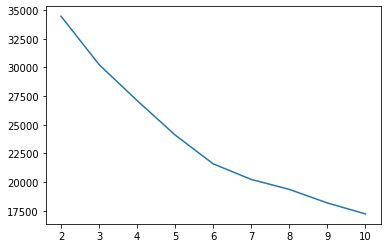

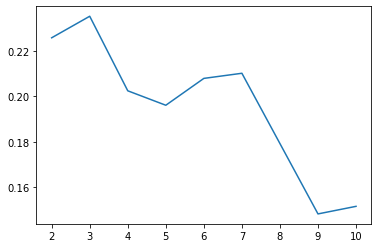

In [1090]:
ks = range(2, 11)

inertias = []
sils = []

for k in ks:
  model = KMeans(n_clusters=k)
  model.fit(x_scaled)
  inertias.append(model.inertia_)
  sils.append(silhouette_score(x_scaled, model.labels_))

plt.plot(ks, inertias)

plt.show()

plt.plot(ks, sils);

Our inertia graph doesnt have clear elbow but our silhouette score gives us a very defined number of clusters with 3.

In [1091]:
kmeans_model = KMeans(n_clusters=3, random_state=42)

kmeans_model.fit(x_scaled)

KMeans(n_clusters=3, random_state=42)

Before going forward I just want to plot our clusters and see if we can learn anything about our features relationships.

In [1092]:
df['cluster'] = kmeans_model.labels_
cluster_groups = df.groupby('cluster', as_index=False).mean()
cluster_groups

,cluster,release_year,runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,0,1997.512376,111.178218,7.040763,172981.819307,66.841097,6.936654
1,1,2017.661380,41.623232,7.036076,8793.608658,20.713539,7.531689
2,2,2017.196155,100.611926,6.084574,11115.651026,17.608671,6.259921


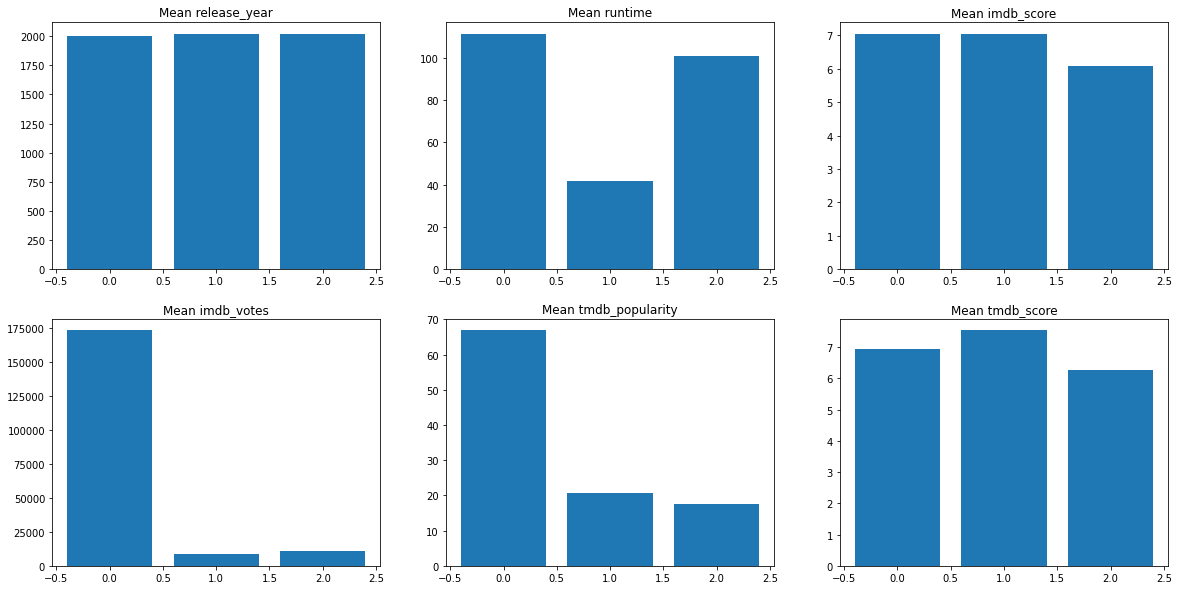

In [1093]:
fig, axes = plt.subplots(2,3, figsize = (20, 10))
axes = axes.ravel()
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')

In [1094]:
df.groupby('cluster')['runtime'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,404.0,111.178218,43.332381,10.0,91.0,111.0,136.0,251.0
1,2333.0,41.623232,20.747810,0.0,25.0,42.0,53.0,131.0
2,3069.0,100.611926,26.683748,10.0,89.0,100.0,115.0,240.0


 So our 3 clusters are not evenly split by the number of points present in each cluster.  It look like cluster 1 is mostly shows based on the average runtime with cluster 0 and 2 being mostly movies or long shows. The average imdb score between cluster 0 and cluster 1 are very close.
Cluster 1 also has the highest mean score from tmdb as well. 

##Supervised Modeling
## Bagging Regressor

In [1095]:
bagreg = BaggingRegressor(random_state = 42)

In [1096]:
bagreg.fit(X_train_pro, y_train)

BaggingRegressor(random_state=42)

In [1097]:
bagreg.predict(X_test_pro)

array([6.34, 6.92, 6.3 , ..., 6.11, 7.42, 6.72])

In [1098]:
bagreg_train_score = bagreg.score(X_train_pro, y_train)
bagreg_test_score = bagreg.score(X_test_pro, y_test)
print(bagreg_train_score)
print(bagreg_test_score)

0.9046865371590054
0.49714588186038744


This model is extremly overfit, I'm going to tune it and see if I can get better results.

In [1099]:
# List of estimator values
estimators = [10, 20, 30, 40, 50, 100]
# Data frame to store the scores
scores = pd.DataFrame(index=estimators, columns=['Train Score', 'Test Score'])
# Iterate through the values to find the best number of estimators
for num_estimators in estimators:
   bag_reg = BaggingRegressor(n_estimators=num_estimators, random_state=42)
   bag_reg.fit(X_train_pro, y_train)
   train_score = bag_reg.score(X_train_pro, y_train)
   test_score = bag_reg.score(X_test_pro, y_test)
   scores.loc[num_estimators, 'Train Score'] = train_score
   scores.loc[num_estimators, 'Test Score'] = test_score

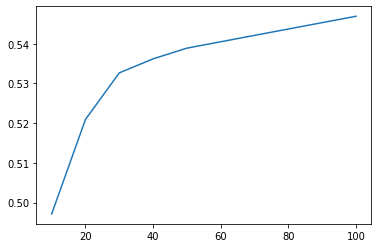

In [1100]:
# Plot the scores
plt.plot(scores['Test Score'])
plt.show()

Sorting my scores next.

In [1101]:
scores = scores.sort_values(by='Test Score', ascending=False)
scores

,Train Score,Test Score
100,0.932656,0.546939
50,0.929549,0.538906
40,0.92757,0.536211
30,0.925164,0.53268
20,0.919158,0.520957
10,0.904687,0.497146


With 100 being the best I'm going to retest with similar numbers.

In [1102]:
# List of estimator values
estimators = [100, 120, 130, 140, 150]
# Data frame to store the scores
scores = pd.DataFrame(index=estimators, columns=['Train Score', 'Test Score'])
# Iterate through the values to find the best number of estimators
for num_estimators in estimators:
   bag_reg = BaggingRegressor(n_estimators=num_estimators, random_state=42)
   bag_reg.fit(X_train_pro, y_train)
   train_score = bag_reg.score(X_train_pro, y_train)
   test_score = bag_reg.score(X_test_pro, y_test)
   scores.loc[num_estimators, 'Train Score'] = train_score
   scores.loc[num_estimators, 'Test Score'] = test_score

In [1103]:
scores = scores.sort_values(by='Test Score', ascending=False)
scores

,Train Score,Test Score
150,0.933984,0.548953
140,0.93381,0.548769
130,0.933611,0.548715
120,0.933325,0.54793
100,0.932656,0.546939


In [1104]:
bag_reg_final = BaggingRegressor(n_estimators=150, random_state=42)
bag_reg_final.fit(X_train_pro, y_train)
train_final = bag_reg_final.score(X_train_pro, y_train)
test_final = bag_reg_final.score(X_test_pro, y_test)
print(train_score)
print(test_score)

0.9339835733640224
0.548953025223951


So even with 150 estimators we are not getting very much in the way of return on our test data (only a .004% increase.)  Lets try a different model.

##Random Forest Regressor

In [1105]:
rf = RandomForestRegressor(random_state = 42)

In [1106]:
rf.fit(X_train_pro, y_train)

RandomForestRegressor(random_state=42)

In [1107]:
rf.predict(X_test_pro)

array([6.453, 6.881, 6.462, ..., 6.03 , 7.265, 6.598])

In [1108]:
rf_train_score = rf.score(X_train_pro, y_train)
rf_test_score = rf.score(X_test_pro, y_test)
print(rf_train_score)
print(rf_test_score)

0.9326314396392981
0.5457741610922928


We are still very overfit.  Lets try changing our depth.

In [1109]:
est_depths = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depths)

32

In [1110]:
depths = range(1, max(est_depths))
scores = pd.DataFrame(index=depths, columns=['Test Score'])
for depth in depths:    
   model = RandomForestRegressor(max_depth=depth)
   model.fit(X_train_pro, y_train)
   scores.loc[depth, 'Train Score'] = model.score(X_train_pro, y_train)
   scores.loc[depth, 'Test Score'] = model.score(X_test_pro, y_test)
   scores.head()

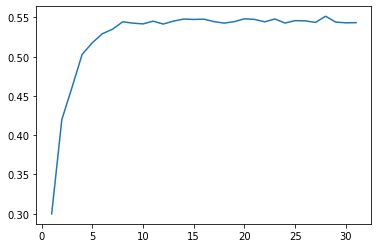

In [1111]:
plt.plot(scores['Test Score']);

In [1112]:
rf_scores = scores.sort_values(by='Test Score', ascending=False)
rf_scores.head()

,Test Score,Train Score
28,0.551522,0.935219
20,0.548269,0.931621
23,0.548057,0.933415
14,0.547943,0.902999
16,0.547803,0.921014


30 is our best depth so lets start with that and move on to tuning our number of estimators.

In [1113]:
n_ests = [50, 100, 150, 200, 250]
scores2 = pd.DataFrame(index=n_ests, columns=['Test Score', 'Train Score'])
for n in n_ests:
   model = RandomForestRegressor(max_depth=30, n_estimators=n)
   model.fit(X_train_pro, y_train)
   scores2.loc[n, 'Train Score'] = model.score(X_train_pro, y_train)
   scores2.loc[n, 'Test Score'] = model.score(X_test_pro, y_test)
scores2.head()

,Test Score,Train Score
50,0.540067,0.930978
100,0.544447,0.933161
150,0.549226,0.933674
200,0.54901,0.934866
250,0.549256,0.935217


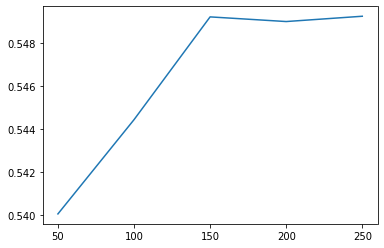

In [1114]:
plt.plot(scores2['Test Score'])
plt.xticks(n_ests);

In [1115]:
sorted_scores2 = scores2.sort_values(by='Test Score', ascending=False)
sorted_scores2.head()

,Test Score,Train Score
250,0.549256,0.935217
150,0.549226,0.933674
200,0.54901,0.934866
100,0.544447,0.933161
50,0.540067,0.930978


In [1116]:
rf_model = RandomForestRegressor(max_depth=21, n_estimators=200)
rf_model.fit(X_train_pro, y_train)
rf_train_final_score = rf_model.score(X_train_pro, y_train)
rf_test_final_score = rf_model.score(X_test_pro, y_test)
print(rf_train_final_score)
print(rf_test_final_score)
print(rf_train_score)
print(rf_test_score)

0.9332428598371255
0.5480450871621396
0.9326314396392981
0.5457741610922928


So here we can see that our basic model is very close to our tuned model in terms of prediction.

Perhaps some PCA feature extraction can help us. The X_train_pro is already scaled so we can just run PCA and our model.

In [1117]:
pca = PCA(n_components=.80)

In [1118]:
%%time
pca_pipe = make_pipeline(pca, rf_model)
pca_pipe.fit(X_train_pro, y_train)

CPU times: user 3.6 s, sys: 128 ms, total: 3.73 s
Wall time: 3.6 s


In [1119]:
pca_preds = pca_pipe.predict(X_test_pro)

In [1120]:
print('Training accuracy:', pca_pipe.score(X_train_pro, y_train))
print('Testing accuracy:', pca_pipe.score(X_test_pro, y_test))

Training accuracy: 0.9233182811416273
Testing accuracy: 0.467776342902132


So here we see that our model has done even worse now with the addition of PCA.

## Metrics

### Bag metrics

In [1121]:
bag_train_pred = bag_reg_final.predict(X_train_pro)
bag_test_pred = bag_reg_final.predict(X_test_pro)

In [1122]:
train_r2 = np.corrcoef(y_train, bag_train_pred)[0][1]**2
test_r2 = np.corrcoef(y_test, bag_test_pred)[0][1]**2
print(f'Model Trainging R2: {train_r2}')
print(f'Model Testing R2: {test_r2}')

Model Trainging R2: 0.9476661663423006
Model Testing R2: 0.5505274790247828


So this is ok news the model can account for almost 95% of the variance in the y_test.

In [1123]:
bag_train_MSE = mean_squared_error(y_train, bag_train_pred)
bag_test_MSE = mean_squared_error(y_test, bag_test_pred)
print(f'Model Training MSE: {bag_train_MSE}')
print(f'Model Testing MSE: {bag_test_MSE}')

Model Training MSE: 0.08840538863649117
Model Testing MSE: 0.6187501212885862


So here we see that our predictions are off by over 60%, not close at all.

In [1124]:
bag_train_RMSE = np.sqrt(bag_train_MSE)
bag_test_RMSE = np.sqrt(bag_test_MSE)
print(f'Model Training RMSE: {bag_train_RMSE}')
print(f'Model Testing RMSE: {bag_test_RMSE}')

Model Training RMSE: 0.29733043678118654
Model Testing RMSE: 0.7866067132236961


Same for root mean squared error while were only off by 29% roughly 3 points in our training set our predictions are off by nearly 80%.

## Conclusion
After all this work and time I hate to admit it but I do not see any of these models as being real world ready.  I think I do not have enough relevant data to make accurate predictions.  If I had no choice but to choose a model I would endorse the Random Forest tuned model as it gave us the highest test results at 55%.  The metrics we just read from our bagging model (the one without pca) show how dismal a job that model does at predicting even having training data to work off of. 
